<a href="https://colab.research.google.com/github/ak1909552/Artificial-Neural-Networks/blob/main/assignments/assignment2/AbhigyanKishor_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as mp

## The MNIST_CNN class

The MNIST_CNN class creates a convolutional neural network to detect and classify features of the [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) dataset. The data has the following classes:

| Index | Description |
| ----- | ----------- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

The dataset contains images corresponding to the above listed class. Each image is a grayscale image of dimension **28x28**. 

Following is a representation of the model:
<img src='https://raw.githubusercontent.com/ak1909552/hostgifs/main/cnn_model.drawio.png'>

In pytorch it is represented as:
```terminal
<bound method Module.named_parameters of MNIST_CNN(
  (c2d1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (c2d2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(6, 6), stride=(2, 2))
    (1): ReLU()
  )
  (c2d3): Sequential(
    (0): Conv2d(12, 32, kernel_size=(6, 6), stride=(2, 2))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=288, out_features=10, bias=True)
    (2): Softmax(dim=1)
  )
)>
```


In [ ]:
class MNIST_CNN(nn.Module):
    
    def __init__(self, activation = None, drop = 0.0):

        
        super().__init__()
        
        
        # Different activations that you can use in forward() method.
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.identity = nn.Identity()

        self.dropout = nn.Dropout(p = drop)

        '''
        self.activation is the activation function determined by the constructor argument
        Defaults to self.relu
        '''
        
        if activation == 'sigmoid':
            self.activation = self.sigmoid
        elif activation == 'tanh':
            self.activation = self.tanh
        elif activation == 'identity':
            self.activation = self.identity
        else:
            self.activation = self.relu
        
        
        self.c2d1 = nn.Sequential(
            nn.Conv2d(1, 12, (3,3)),
            self.activation
        )

        self.c2d2 = nn.Sequential(
            nn.Conv2d(12, 12, (6,6), 2),
            self.activation
        )

        self.c2d3 = nn.Sequential(
            nn.Conv2d(12, 32, (6,6), 2),
            self.activation
        )

        self.fc1 = nn.Sequential(
            self.dropout,
            nn.Linear(32*3*3, 10),
            nn.Softmax(1)
        )

    
    def forward(self, input):
               
        # Switch from activation maps to vectors
        out = self.c2d1(input)
        out = self.c2d2(out)
        out = self.c2d3(out)
        out = out.view(-1, 288)
        out = self.fc1(out)
        return out
    
    # This function maps the network on the device that is passed as argument.
    # If your device doesn't have a GPU, it set device='cpu'.
    def set_device(self, device):
        self.device = device
        self.to(self.device)
    
    # This function trains the model on the data passed as arguments.        


    def fit(self, mnist_train_loader, num_epochs=1, mnist_valid_loader=None):
        train_loss_history = []
        train_acc_history = []
        valid_loss_history = []
        valid_acc_history = []
        
        for epoch in range(num_epochs):
            
            self.train() # Set to the training mode.
            iter_loss = 0
            iter_acc = 0
            for i, (items, classes) in enumerate(mnist_train_loader):
                items = Variable(items).to(self.device)
                classes = Variable(classes).to(self.device)

                self.optimizer.zero_grad()     # Clear off the gradients from any past operation
                outputs = self.forward(items)      # Do the forward pass
                loss = self.criterion(outputs, classes) # Calculate the loss
                loss.backward()           # Calculate the gradients with help of back propagation
                self.optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
                iter_loss += loss.data # Accumulate the loss
                iter_acc += (torch.max(outputs.data, 1)[1] == classes.data).sum()
                print("\r", i + 1, "/", len(mnist_train_loader), ", Loss: ", loss.data/len(items), end="")
            train_loss_history += [iter_loss.cpu().detach().numpy()]
            train_acc_history += [(iter_acc/len(mnist_train_loader.dataset)).cpu().detach().numpy()]
            print("\tTrain: ", train_loss_history[-1], train_acc_history[-1], end="")
            
            self.eval() # Set to the evaluation mode.
            iter_loss = 0
            iter_acc = 0
            for i, (items, classes) in enumerate(mnist_valid_loader):
                items = Variable(items).to(self.device)
                classes = Variable(classes).to(self.device)

                outputs = self(items)      # Do the forward pass
                iter_loss += self.criterion(outputs, classes).data
                iter_acc += (torch.max(outputs.data, 1)[1] == classes.data).sum()
            valid_loss_history += [iter_loss.cpu().detach().numpy()]
            valid_acc_history += [(iter_acc/len(mnist_valid_loader.dataset)).cpu().detach().numpy()]
            print("\tValidation: ", valid_loss_history[-1], valid_acc_history[-1])
        
        return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history



## The `mnist_loader()` function

In [ ]:
def mnist_loader(batch_size=512, classes=None):
    transform=transforms.Compose([transforms.ToTensor()])
    mnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    mnist_valid = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    
    # Select the classes which you want to train the classifier on.
    if classes is not None:
        mnist_train_idx = (mnist_train.targets == -1)
        mnist_valid_idx = (mnist_valid.targets == -1)
        for class_num in classes:
            mnist_train_idx |= (mnist_train.targets == class_num)
            mnist_valid_idx |= (mnist_valid.targets == class_num) 
        
        mnist_train.targets = mnist_train.targets[mnist_train_idx]
        mnist_valid.targets = mnist_valid.targets[mnist_valid_idx]
        mnist_train.data = mnist_train.data[mnist_train_idx]
        mnist_valid.data = mnist_valid.data[mnist_valid_idx]
    
    mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)
    return mnist_train_loader, mnist_valid_loader

## Setting the device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## A. Visualizing the model

<img src='https://raw.githubusercontent.com/ak1909552/hostgifs/main/cnn_model.drawio.png'>

## B. Number of trainable parameters

Each layer (convolutional or linear) has its corresponing weights and biases that need to be trained. The following code iterates over these parameters and returns the sum.

In [ ]:
model = MNIST_CNN(activation='relu', drop=0)
sum = 0
str = 'model = '
for name, params in model.named_parameters():
    str = str + f'{name} '
    sum = sum + torch.numel(params)
print(str)
sum


model = c2d1.0.weight c2d1.0.bias c2d2.0.weight c2d2.0.bias c2d3.0.weight c2d3.0.bias fc1.1.weight fc1.1.bias 


22062

## C. Running the model

The model is run for 20 epochs and the following sample result is obtained:

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

 600 / 600 , Loss:  tensor(0.0172, device='cuda:0')	Train:  1149.1465 0.5913167	Validation:  175.54227 0.7169
 600 / 600 , Loss:  tensor(0.0169, device='cuda:0')	Train:  1040.1722 0.73683333	Validation:  172.6761 0.7427
 600 / 600 , Loss:  tensor(0.0168, device='cuda:0')	Train:  1026.411 0.75815	Validation:  170.96428 0.75689995
 600 / 600 , Loss:  tensor(0.0167, device='cuda:0')	Train:  1018.86285 0.76816666	Validation:  169.89258 0.7682
 600 / 600 , Loss:  tensor(0.0169, device='cuda:0')	Train:  1012.977 0.77763337	Validation:  169.2955 0.7718
 600 / 600 , Loss:  tensor(0.0163, device='cuda:0')	Train:  1007.5561 0.7865667	Validation:  168.54697 0.7772
 600 / 600 , Loss:  tensor(0.0168, device='cuda:0')	Train:  1002.0463 0.79593337	Validation:  167.8042 0.78999996
 600 / 600 , Loss:  tensor(0.0173, device='cuda:0')	Train:  997.4598 0.80441666	Validation:  167.33418 0.7934
 600 / 600 , Loss:  tenso

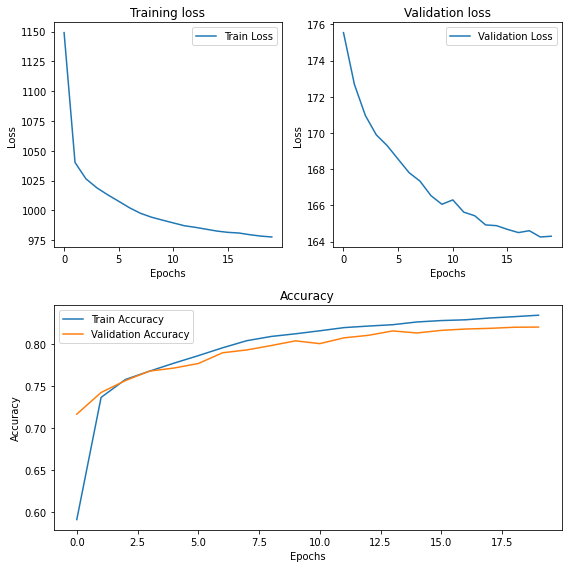

In [ ]:
batch_size = 100
mnist_train_loader, mnist_valid_loader = mnist_loader(batch_size=batch_size)
model.set_device(device)
# Our loss function and Optimizer

model.criterion = nn.CrossEntropyLoss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr is the learning_rate
# Train model for 20 epochs
tlh, tah, vlh, vah = model.fit(mnist_train_loader, num_epochs=20, mnist_valid_loader=mnist_valid_loader)



figure = plt.figure(figsize=(8, 8))
rows, cols = 2,2

figure.add_subplot(rows, 1, 2)

plt.title(f'Accuracy')
plt.plot(tah, label='Train Accuracy')
plt.plot(vah, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()


figure.add_subplot(rows,2, 1)

plt.title(f'Training loss')
plt.plot(tlh, label='Train Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()

figure.add_subplot(rows, 2, 2)

plt.title(f'Validation loss')
plt.plot(vlh, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()

plt.show()

The CNN consistently reaches 82-83% accuracy.

### Further training

The model is trained further to see signs of overfitting. However, architecturally, this model is too simple to result in significant overfitting.

CNN models are often overfit when they have a lot of fully connected layers. However, this model has only 1 and so it does not significantly overfit.

 600 / 600 , Loss:  tensor(0.0160, device='cuda:0')	Train:  976.4658 0.8361667	Validation:  164.34804 0.81909996
 600 / 600 , Loss:  tensor(0.0158, device='cuda:0')	Train:  975.7321 0.83750004	Validation:  163.89397 0.82379997
 600 / 600 , Loss:  tensor(0.0164, device='cuda:0')	Train:  974.78577 0.83925	Validation:  163.98996 0.8215
 600 / 600 , Loss:  tensor(0.0160, device='cuda:0')	Train:  973.9659 0.8412	Validation:  163.49416 0.8287
 600 / 600 , Loss:  tensor(0.0161, device='cuda:0')	Train:  973.03375 0.84181666	Validation:  163.492 0.8271
 600 / 600 , Loss:  tensor(0.0159, device='cuda:0')	Train:  972.5312 0.8423333	Validation:  163.37427 0.82989997
 600 / 600 , Loss:  tensor(0.0161, device='cuda:0')	Train:  971.36194 0.84445	Validation:  163.47769 0.82799995
 600 / 600 , Loss:  tensor(0.0161, device='cuda:0')	Train:  970.72174 0.8457	Validation:  163.06725 0.83129996
 600 / 600 , Loss:  tensor(0.0161, device='cuda:0')	Train:  969.8182 0.8469167	Validation:  162.87537 0.8351
 600 

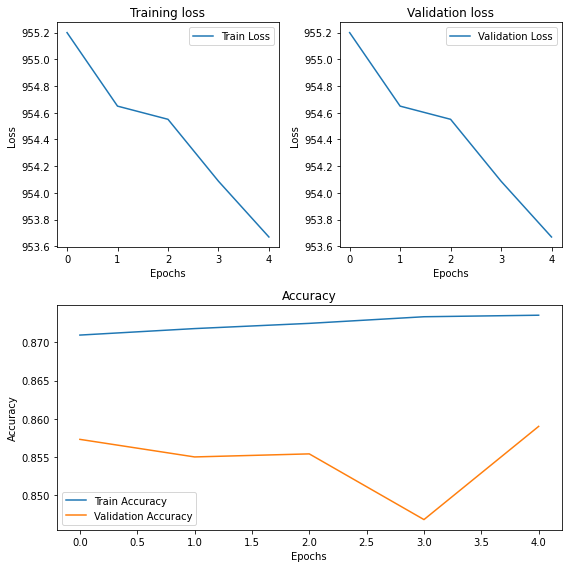

In [ ]:
model.criterion = nn.CrossEntropyLoss()
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr is the learning_rate
model.fit(mnist_train_loader, num_epochs=40, mnist_valid_loader=mnist_valid_loader)
tlh, tah, vlh, vah = model.fit(mnist_train_loader, num_epochs=5, mnist_valid_loader=mnist_valid_loader)



figure = plt.figure(figsize=(8, 8))
rows, cols = 2,2

figure.add_subplot(rows, 1, 2)

plt.title(f'Accuracy')
plt.plot(tah, label='Train Accuracy')
plt.plot(vah, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.tight_layout()


figure.add_subplot(rows,2, 1)

plt.title(f'Training loss')
plt.plot(tlh, label='Train Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()

figure.add_subplot(rows, 2, 2)

plt.title(f'Validation loss')
plt.plot(tlh, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()

plt.show()

The model shows sign of overfitting with fluctutations in validation accuracies.

## D. With Dropout

Dropout is a form of regularization in which, during training, the model deactivates a certain percentage of neurons in a certain layer. This enforces each neuron to learn more independantly and robustly. In the following code, I show results for dropout 0.2, 0.4 and 0.5.


 drop = 0.2
 600 / 600 , Loss:  tensor(0.0179, device='cuda:0')	Train:  1148.7239 0.59125	Validation:  175.67432 0.71199995
 600 / 600 , Loss:  tensor(0.0177, device='cuda:0')	Train:  1047.95 0.7217	Validation:  172.83226 0.73969996
 600 / 600 , Loss:  tensor(0.0180, device='cuda:0')	Train:  1031.6843 0.7463167	Validation:  170.87871 0.75549996
 600 / 600 , Loss:  tensor(0.0172, device='cuda:0')	Train:  1021.89044 0.7628667	Validation:  169.50125 0.7715
 600 / 600 , Loss:  tensor(0.0172, device='cuda:0')	Train:  1014.38165 0.7744667	Validation:  168.43684 0.7836
 600 / 600 , Loss:  tensor(0.0167, device='cuda:0')	Train:  1008.3708 0.785	Validation:  167.60477 0.7899
 600 / 600 , Loss:  tensor(0.0175, device='cuda:0')	Train:  1004.015 0.79163337	Validation:  167.1556 0.7952
 600 / 600 , Loss:  tensor(0.0165, device='cuda:0')	Train:  1000.2807 0.79843336	Validation:  166.5822 0.79899997
 600 / 600 , Loss:  tensor(0.0168, device='cuda:0')	Train:  997.4847 0.8020167	Validation:  166.29614

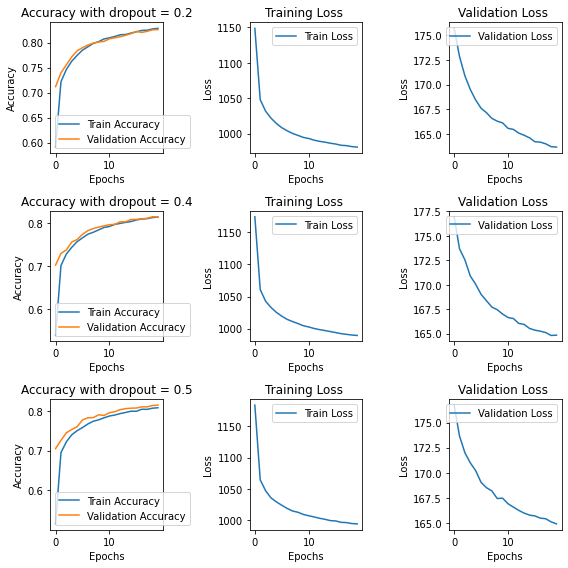

In [ ]:
batch_size = 100
mnist_train_loader, mnist_valid_loader = mnist_loader(batch_size=batch_size)



drops = [0.2, 0.4, 0.5]
figure = plt.figure(figsize=(8, 8))
rows, cols = (3,3)
for i, d in enumerate(drops):
    print(f'\n drop = {d}')
    model_drop = MNIST_CNN(activation='relu', drop = d)
    model_drop.set_device(device)
    # Our loss function and Optimizer

    model_drop.criterion = nn.CrossEntropyLoss()
    model_drop.optimizer = torch.optim.Adam(model_drop.parameters(), lr=0.0001) #lr is the learning_rate
    # Train model for 20 epochs
    tlh, tah, vlh, vah = model_drop.fit(mnist_train_loader, num_epochs=20, mnist_valid_loader=mnist_valid_loader)

    figure.add_subplot(rows,cols, 3*i + 1)
    
    plt.title(f'Accuracy with dropout = {d}')
    plt.plot(tah, label='Train Accuracy')
    plt.plot(vah, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.tight_layout()


    figure.add_subplot(rows,cols, 3*i + 2)

    plt.title(f'Training Loss ')
    plt.plot(tlh, label='Train Loss')
    # plt.plot(vlh, label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.tight_layout()

    figure.add_subplot(rows,cols, 3*i + 3)

    plt.title(f'Validation Loss ')
    # plt.plot(tlh, label='Train Loss')
    plt.plot(vlh, label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.tight_layout()

plt.show()




Steady decrease in loss indicates that dropout is indeed helping. As before dropout requires longer training time, however, the accuracies achieved are promising.

## E. Visualizing the output

The following code visualizes the output of the 2 models (model with dropout and model without) against the truth labels of the dataset.

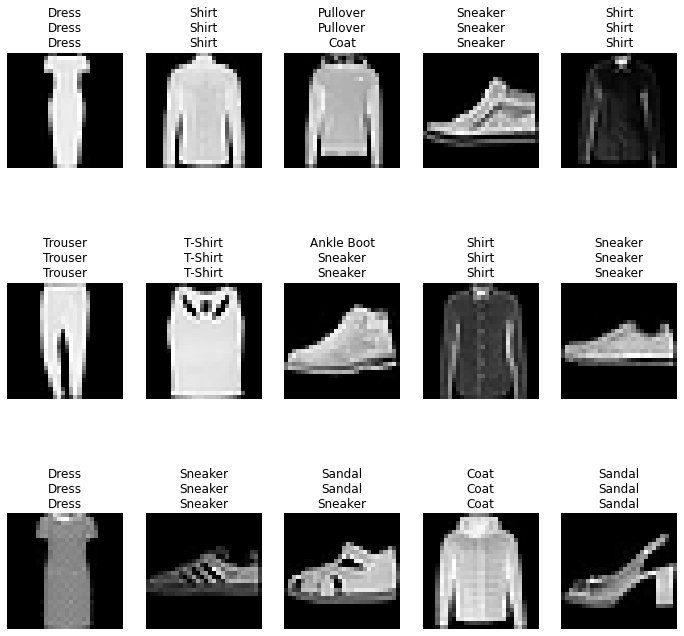

In [ ]:
import numpy as np
transform=transforms.Compose([transforms.ToTensor()])
training_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(12, 12))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = Variable(img).to(device)
    
    output = model(img)
    output_drop = model_drop(img)

    output = output.cpu().detach().numpy()
    output_drop = output_drop.cpu().detach().numpy()

    figure.add_subplot(rows, cols, i)
    plt.title(f'{labels_map[label]}\n{labels_map[np.argmax(output)]}\n{labels_map[np.argmax(output_drop)]}')
    plt.axis("off")
    plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
plt.show()


### Saliency maps

Saliency maps are a visualization tool which show pixels responsible for maximum activation of a certain class of output. 
In the following code, we first pass a sample image through the model, back propogate against the activated class, and return an image with the gradients of each pixel. 

The heat map represents the different gradients per pixel for the activated class. The lighter the color, the greater the gradient and therefore the activation. 

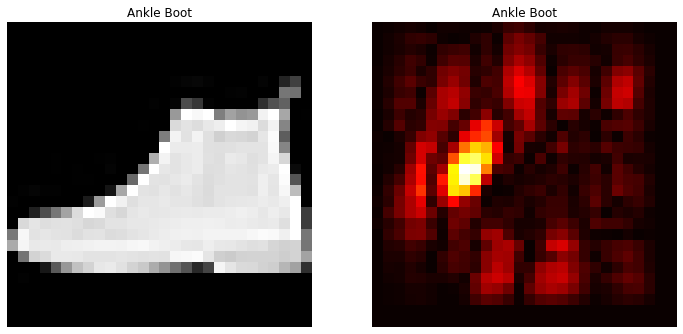

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

transform=transforms.Compose([transforms.ToTensor()])
training_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

img = Variable(img).to(device)

img.requires_grad_()

model.eval()

output = model(img)


output_idx = output.argmax()
output_max = output[0,output_idx]



output_max.backward()



# saliency, _ = torch.max(img.grad.data.abs(),dim=1)
saliency = img.grad.data.abs()

figure = plt.figure(figsize=(12, 12))
cols, rows = 2,1

figure.add_subplot(rows, cols, 1)
plt.title(labels_map[label])
plt.imshow(img.cpu().detach().numpy()[0], cmap='gray')
plt.axis('off')

figure.add_subplot(rows, cols, 2)
plt.title(labels_map[output_idx.item()])
plt.imshow(saliency.cpu().detach().numpy()[0], cmap=plt.cm.hot)
plt.axis('off')

plt.show()

### Visualizing the first layer

The following code creates the heat maps for the first convolution layer of the model to see the various features that they detect.

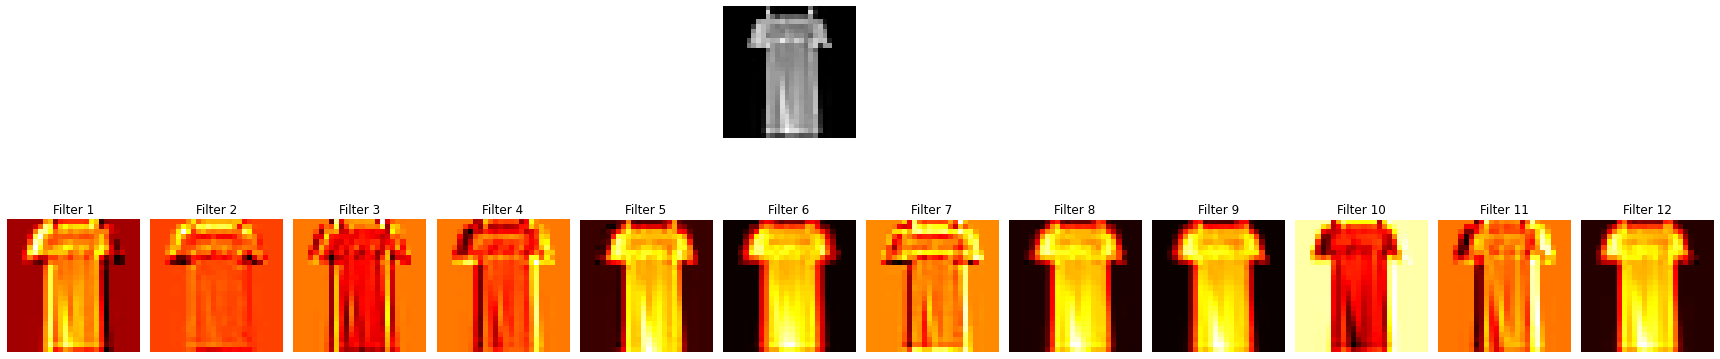

In [ ]:
params = model.named_parameters()
c2d1_weight = next(params)
c2d1_bias = next(params)

c2d1 = nn.Conv2d(1, 12, 3)
c2d1.weight = c2d1_weight[1]
c2d1.bias = c2d1_bias[1]

transform=transforms.Compose([transforms.ToTensor()])
training_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

img = Variable(img).to(device)

output = c2d1(img)

figure = plt.figure(figsize=(24, 12))
rows, cols = 2, 12

for i in range(len(output)):
    figure.add_subplot(1, cols, i+1)
    plt.title(f'Filter {i+1}')
    plt.imshow(output.cpu().detach().numpy()[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.tight_layout()

figure.add_subplot(2, cols, 6)
plt.imshow(img.cpu().detach().numpy()[0], cmap ='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

## Comparison with MLP
The following are the main insights gathered:
1. The CNN architecture provides better accuracy than the MLP.
2. The CNN architecture is more resilient to over-fitting because of the small number of trainable parameters.
3. The MLP performance can be drastically improved using dropout, where as the CNN architecture did not see any improvement. This is attributed to their relative complexities.
4. The patterns looked for by the network are more clear to visualize and comprehend in the CNN as compared to MLP.
5. The CNN training time is slightly longer than the MLP.